In [66]:
import numpy as np
import cv2
import random
import math

import glob
import os

import matplotlib.pyplot as plt

In [33]:
root_dir = r'D:\UAV_obj_det\datasets'

tr_img_dir = 'images\\train'
tr_lab_dir = 'labels\\train'

val_img_dir = 'images\\val'
val_lab_dir = 'labels\\val'

t_img_dir = 'images\\test'
t_lab_dir = 'labels\\test'

classes = ['Person','Car','Bicycle','OtherVechicle','DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [7]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [62]:
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'\\*.jpg')
    all_training_labels = glob.glob(label_path+'\\*.txt')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.title(image_name)
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

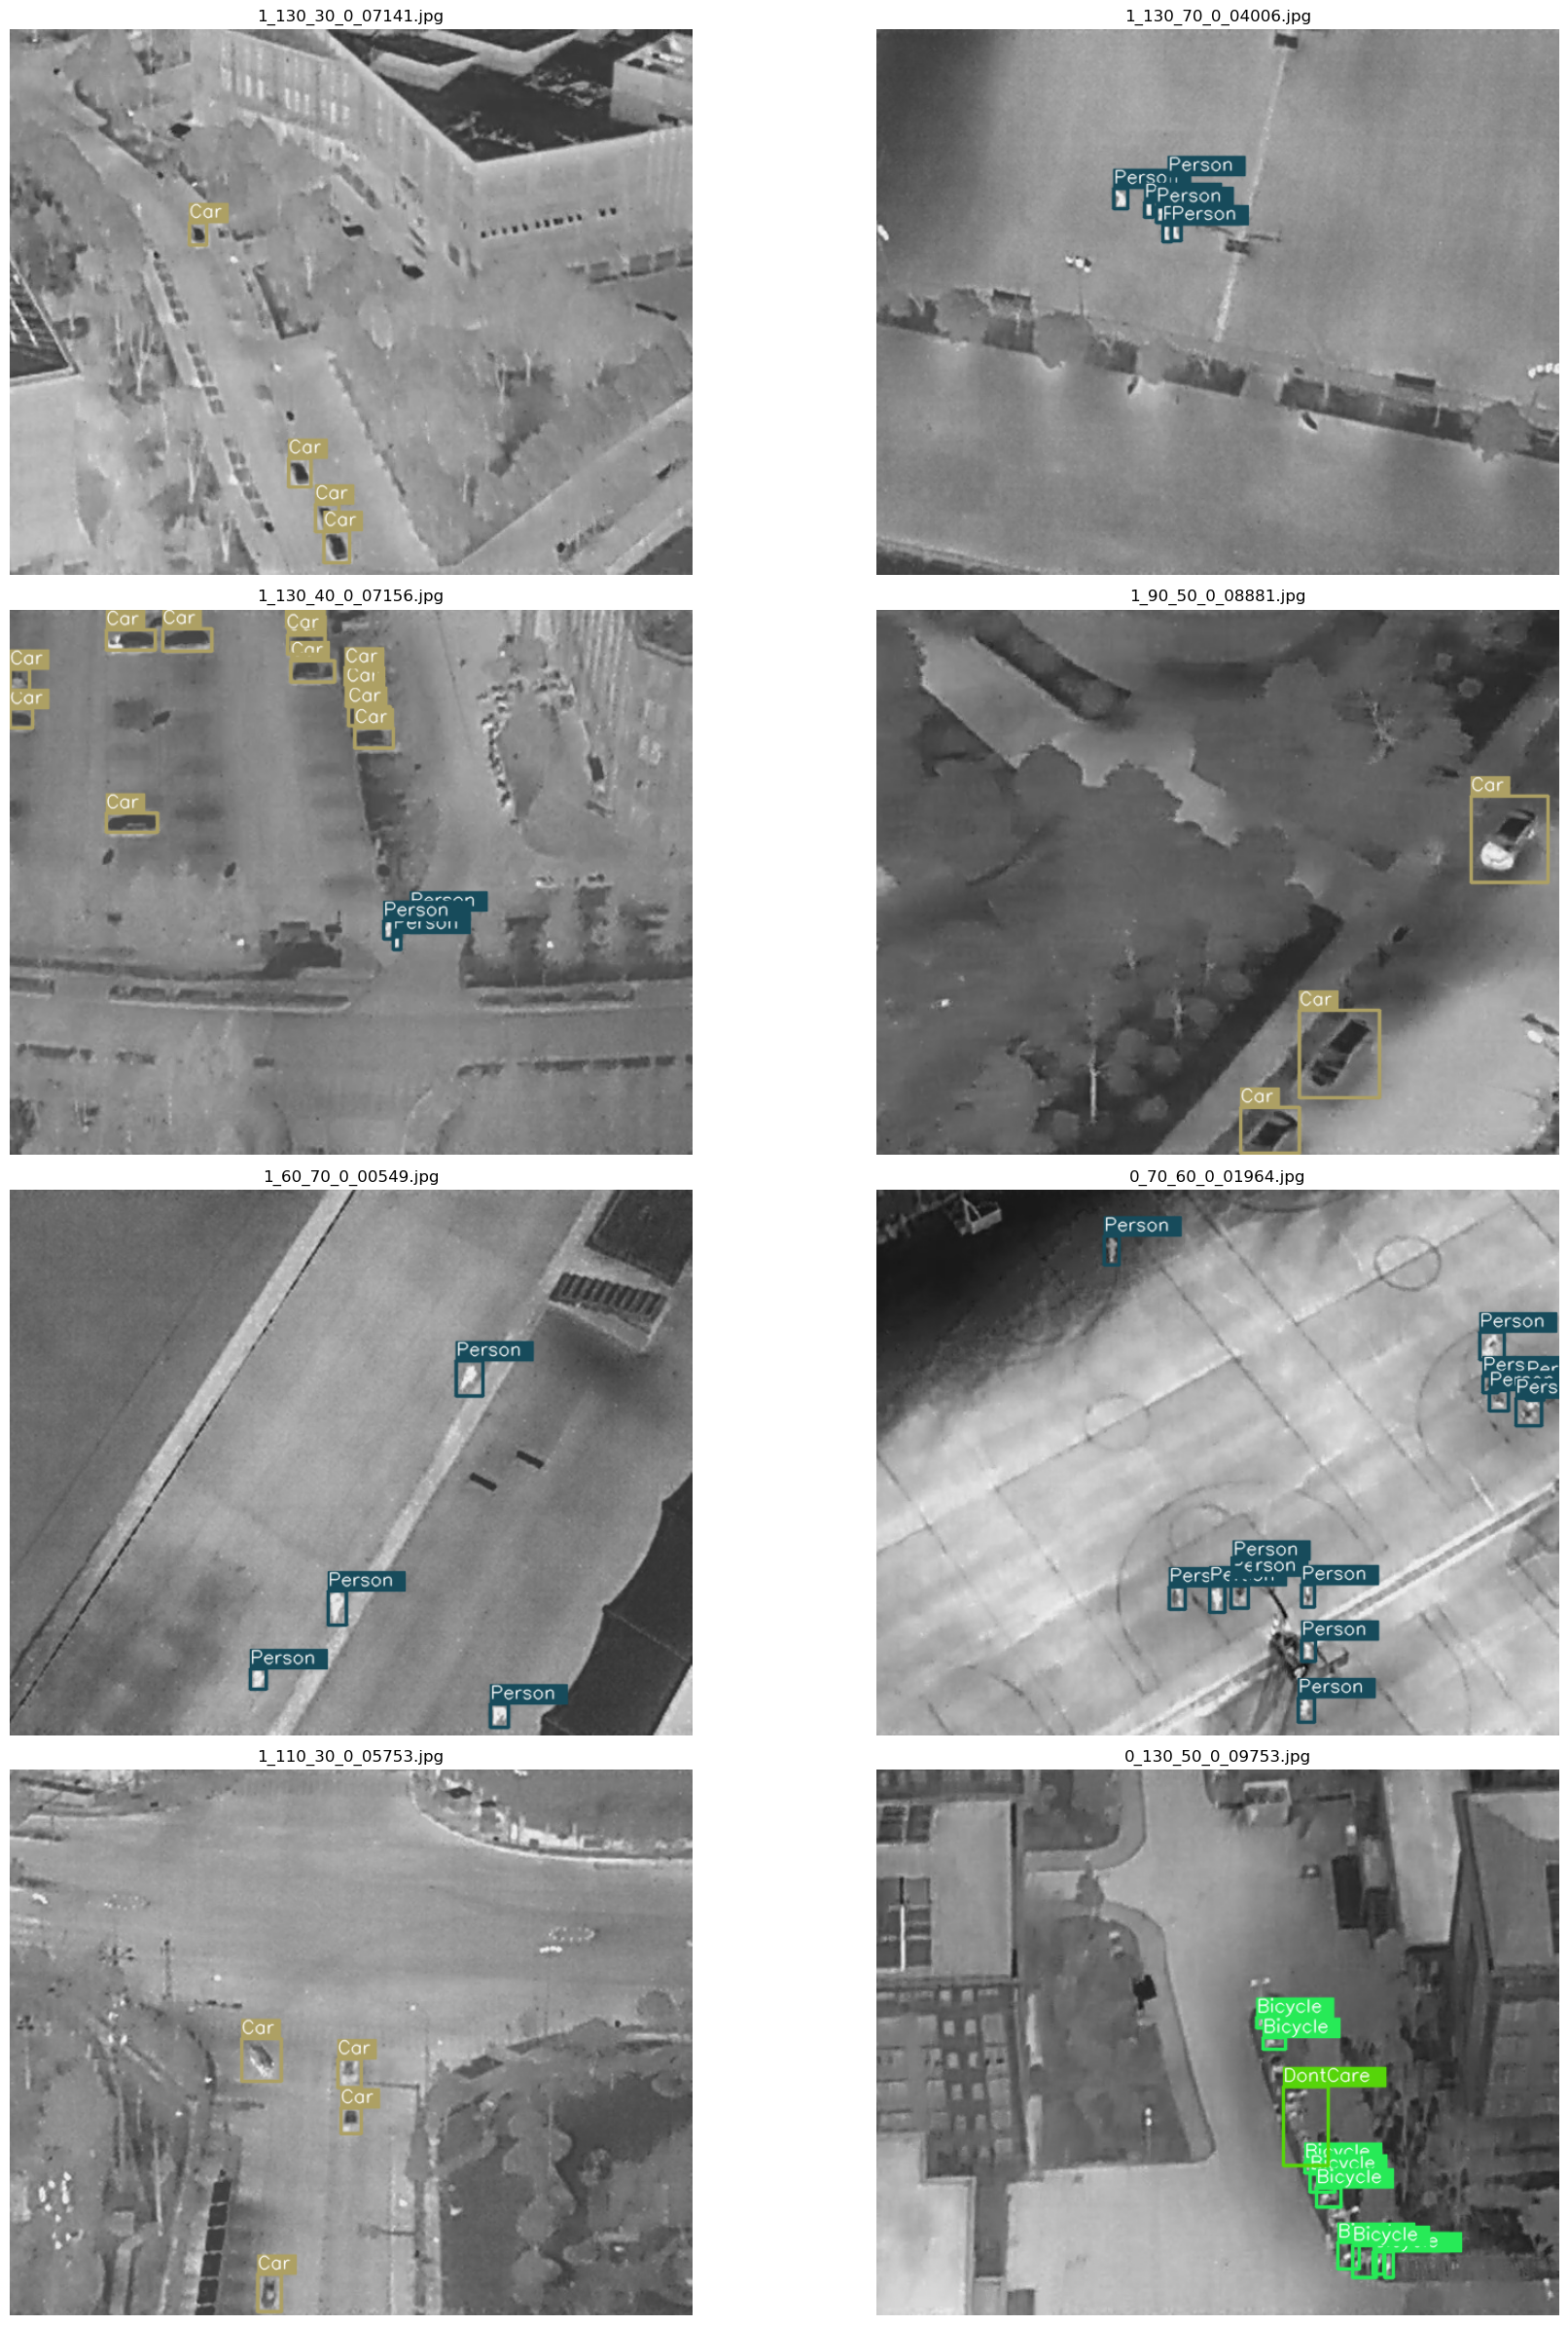

In [64]:
plot(
    image_path=os.path.join(root_dir, tr_img_dir), 
    label_path=os.path.join(root_dir, tr_lab_dir),
    num_samples=8
)